In [1]:
# This line will add a button to toggle visibility of code blocks,
# for use with the HTML export version
from IPython.core.display import HTML
HTML('''<button style="margin:0 auto; display: block;" onclick="jQuery('.code_cell .input_area').toggle();
    jQuery('.prompt').toggle();">Toggle code</button>''')

<script>
    document.querySelector('head').innerHTML += '<style>.slides { zoom: 1. !important; }</style>';
</script>

# Week 9 - Tree-Based Methods
### Dr. David Elliott

4. [Majority Voting](#mv)

5. [Bagging](#bag)

6. [Random Forests](#forest)

__NOTES__

__Question:__ Why not just stick to decision trees? 

__Answer:__ Although they are useful for interpretation, they are not as competative for supervised learning methods, so we'll also talk about bagging, random forests, and boosting; which all rely on producing multiple trees and combining them to gain a single prediction. This typically improves accuracy a lot, but at the expense of interpretability.

The goal of ensemble methods is to combine different classifiers into a metaclassifier that has better generalization performance than each individual classifier alone<sup>4</sup>.

Most popular ensemble methods use the majority (or plurality) voting principle.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
from IPython.display import Image
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import plot_tree
from mlxtend.plotting import plot_decision_regions
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings # prevent warnings
import joblib # saving models
import itertools
from scipy.stats.distributions import uniform, loguniform
from scipy.stats import distributions
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import NeighbourhoodCleaningRule
from sklearn.decomposition import PCA
import timeit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split

matplotlib.rcParams['animation.embed_limit'] = 30000000.0
plt.rcParams['figure.dpi'] = 120

image_dir = os.path.join(os.getcwd(),"Images")
data_dir = os.path.join(os.getcwd(),"..","Data")

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
fig_num=21
plt.rcParams['figure.dpi'] = 120
# golden ratio for figures ()
gr = 1.618

height_pix = 500
width_pix = height_pix*gr

height_inch = 4
width_inch = height_inch*gr

In [3]:
# Centered figures in the notebook and presentation
# ...was a real pain to find this:
# https://gist.githubusercontent.com/maxalbert/800b9f06c7b2dd365ea5

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import urllib
import base64
from io import BytesIO, StringIO

def fig2str(fig, format='svg'):
    """
    Return a string containing the raw data of the matplotlib figure in the given format.

    """
    assert isinstance(fig, matplotlib.figure.Figure)
    imgdata = BytesIO()
    fig.savefig(imgdata, format=format, bbox_inches='tight')
    imgdata.seek(0)  # rewind the data
    output = imgdata.getvalue()
    if format == 'svg':
        return output
    else:
        return urllib.parse.quote(base64.b64encode(output))

class MatplotlibFigure(object):
    """
    Thin wrapper around a matplotlib figure which provides a custom
    HTML representation that allows tweaking the appearance

    """
    def __init__(self, fig, centered=False):
        assert isinstance(fig, matplotlib.figure.Figure)
        self.centered = centered

    def _repr_html_(self):
        img_str_png = fig2str(fig, format='png')
        uri = 'data:image/png;base64,' + img_str_png
        html_repr = "<img src='{}'>".format(uri)
        if self.centered:
            html_repr = "<center>" + html_repr + "</center>"
        return html_repr

In [4]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.2, random_state=42)

# 4. Majority Voting <a id='mv'></a>

Majority voting can be done by simply selecting the class label that has been predicted by the majority of the classifiers (more than 50% of votes).

Majority vote refers to binary class decisions but can be generalized to a multi-class setting using _plurality voting"_<sup>4</sup>.

To predict a class label via simple majority or plurality voting, we start by training $m$ different classifiers ($C_1,\ldots,C_m$), and then combine the predicted labels of each classifier, $C_j$, selecting the class label, $\hat y$, that received the most votes<sup>4</sup>.

__Notes__
- choosing the most commonly voted for class is sometimes called 'hard voting'.
- Scikit-learn has a `VotingClassifier` where multipule classification pipelines can be combined to create a classifier that aggregates predictions.

Figure 22: Majority Voting Classifier


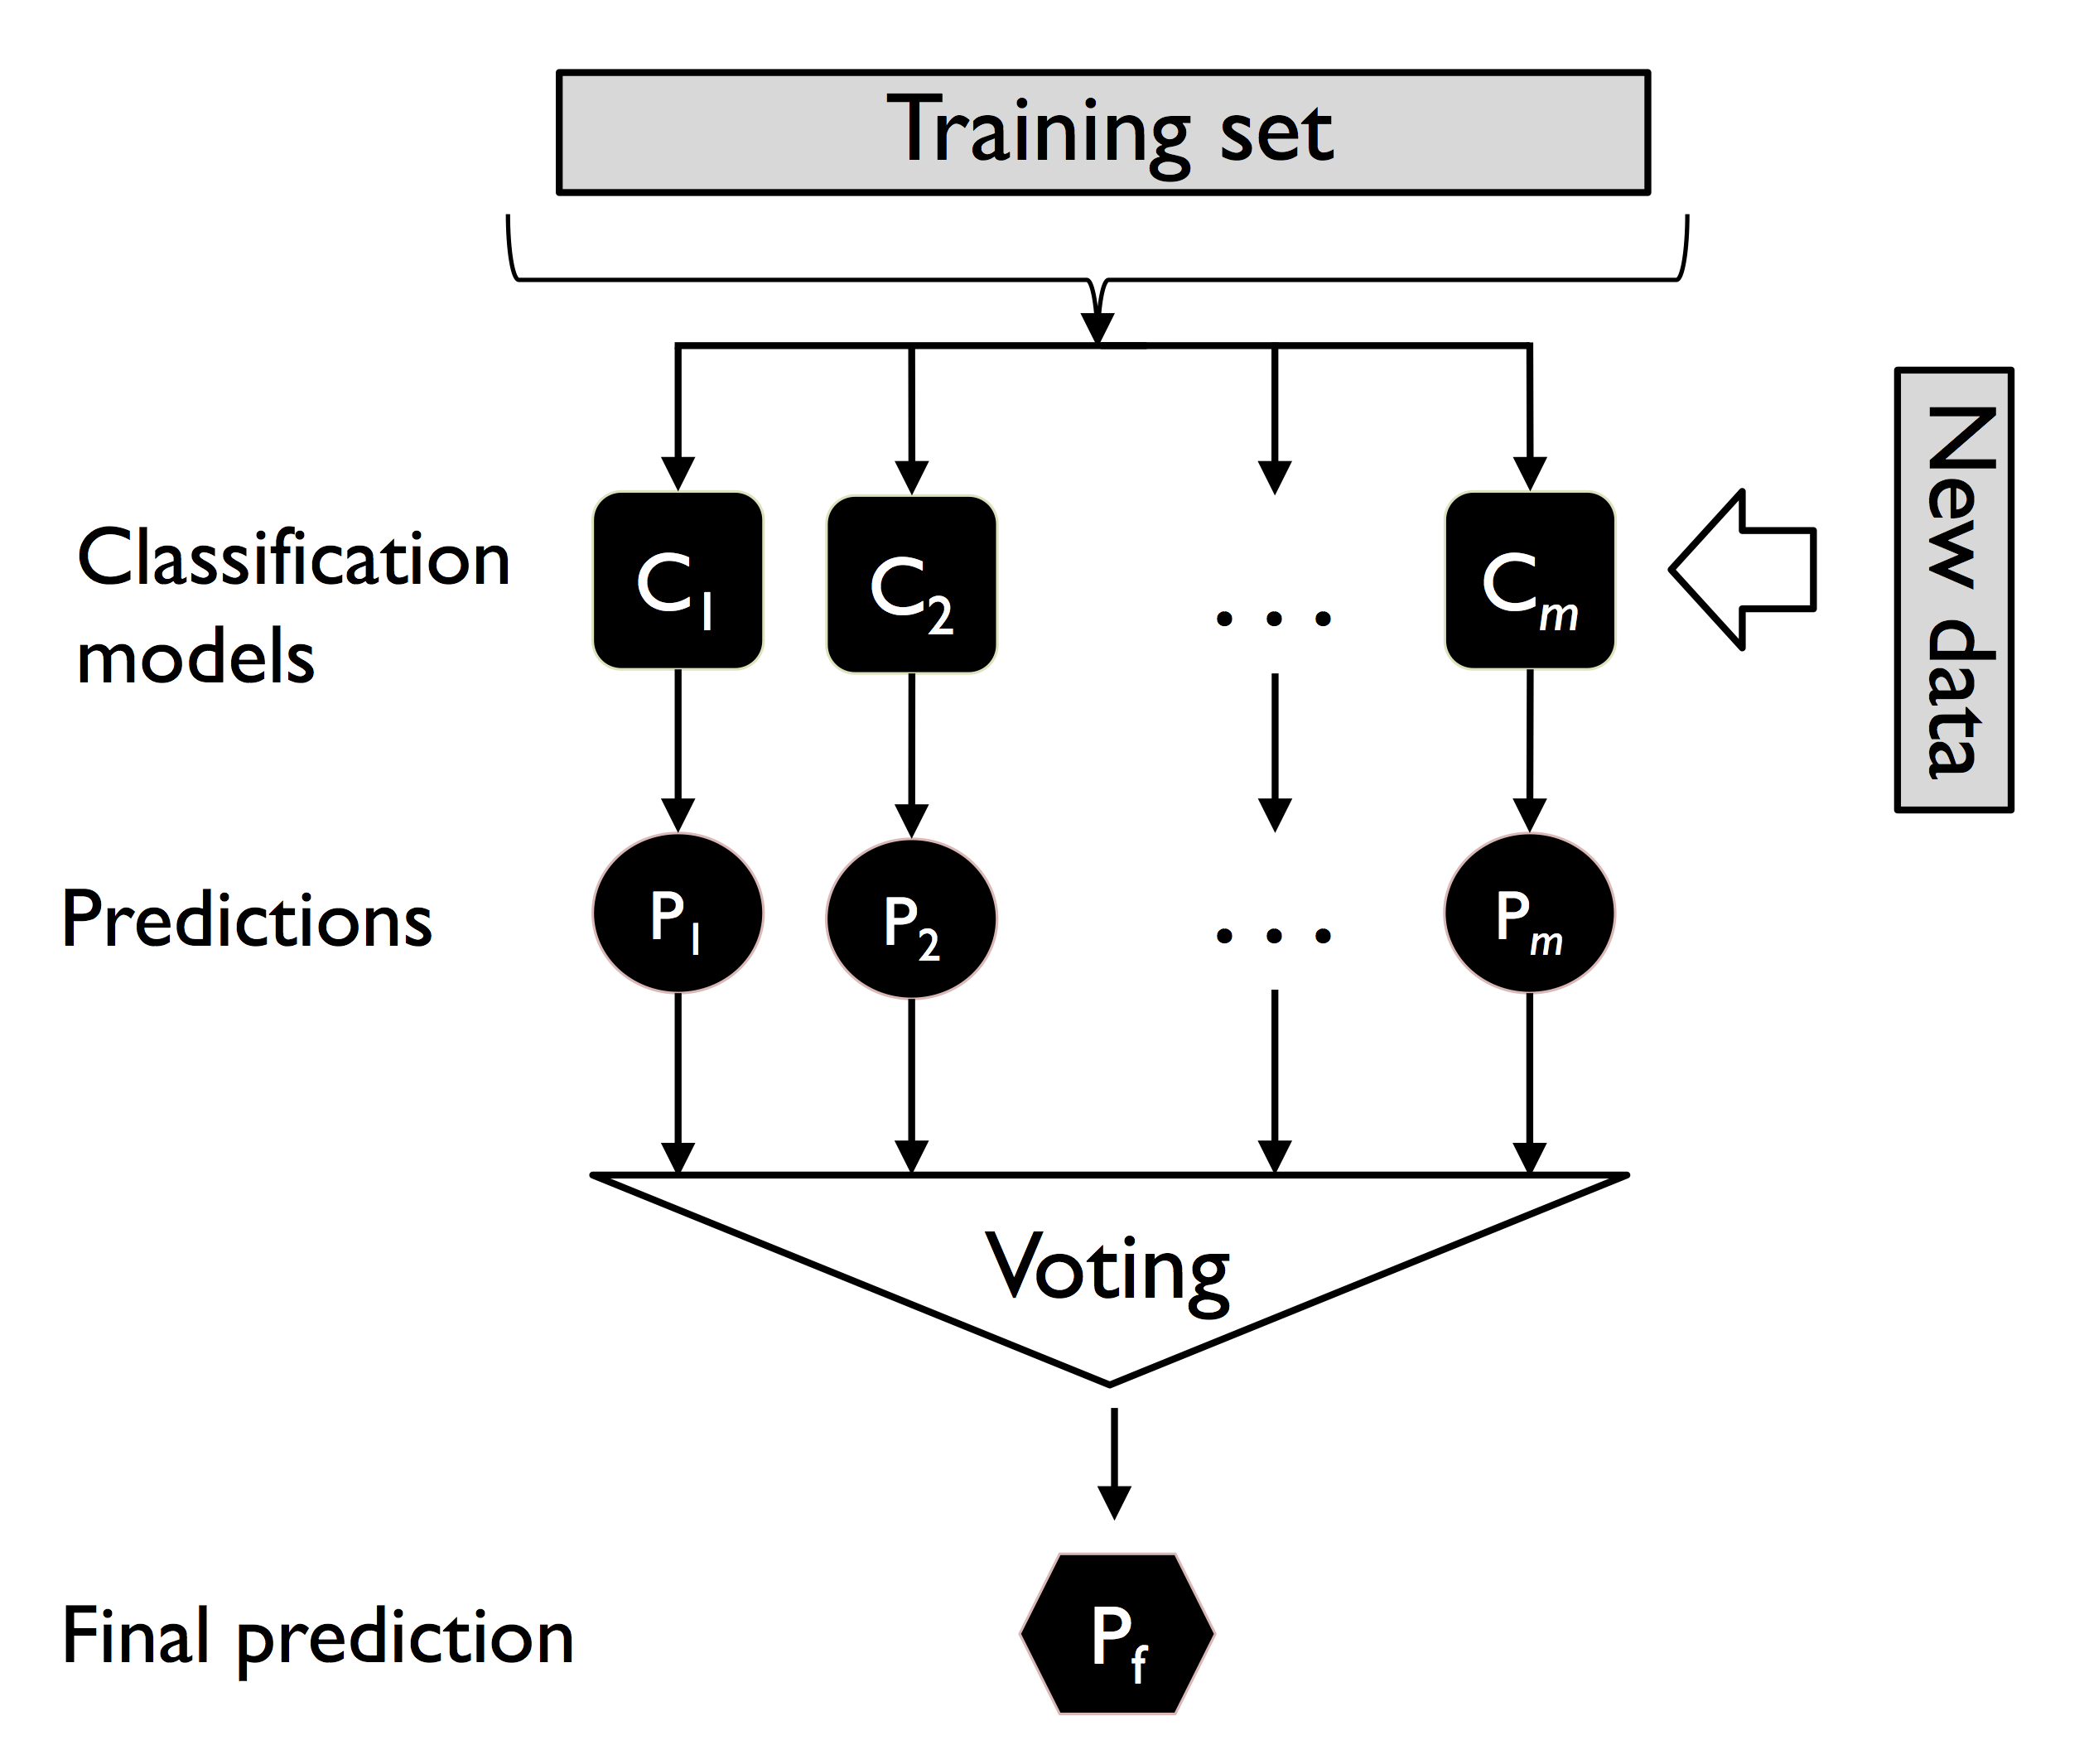

In [5]:
fig_num+=1
print(color.BOLD+color.UNDERLINE+"Figure %d: Majority Voting Classifier"%fig_num+color.END)

# From https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L07/07-ensembles__notes.pdf
#Image(os.path.join(image_dir, "majority_voting.png"), width=600)
# From https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch07/images/07_02.png
Image(os.path.join(image_dir, "07_02.png"), width=600)

In binary classification (-1,1) we can write the majority vote prediction as<sup>4</sup>:

$$
\hat y = \text{mode}\{C_1(x), C_2(x),...,C_m(x)\}
\\
C(x) = \text{sgn}\left[ \sum^m_jC_j(x)\right] = \left\{{1 \: \text{if}\: \sum_j C_j(x) \: \geq \: 0  \atop -1 \: \text{otherwise}} \right\}
$$

Instead we may want to weight the votes:

$$
\hat y = {\arg\max \atop i} \sum^m_{j=1}w_j\mathbb{1}_A(C_j(x)=i)
$$

where $w_j$ is a weight associated with a base classifier, $C_j$ ; $\hat y$ is the predicted class label of the ensemble; $A$ is the set of unique class labels; $\mathbb{1}_A$ is the characteristic function or indicator function, which returns 1 if the predicted class of the $j$th classifier matches $C_j(x)=i$.

Particular classifiers return the probability of a predicted class label and this can be used for _"soft voting"_ instead of class labels<sup>4</sup>. The modified version of the majority vote for predicting class labels from probabilities can be written as:

$$
\hat y = \text{arg} {\text{max} \atop i} \sum^m_{j=1}w_jp_{ij},
$$

where $p_{ij}$ is the predicted probability of the $j$th classifier for class label $i$.

Soft voting often achives a higher performance than hard voting because highly confident votes are given more weight<sup>3</sup>.

__NOTES__

- Scikit-learn uses the `predict_proba` method to compute class probabilities. 
- _"In decision trees, the probabilities are calculated from a frequency vector that is created for each node at training time. The vector collects the frequency values of each class label computed from the class label distribution at that node. Then, the frequencies are normalized so that they sum up to 1...Although the normalised probabilities returned by both the decision tree and k-nearest neighbors classifier may look similar to the probabilities obtained from a logistic regression model, we have to be aware these are actually not derrived from probability mass functions."_<sup>4</sup>

In [6]:
RANDOM_STATE=42

clf1 = Pipeline([('scl', StandardScaler()),
                 ('clf', SVC(kernel='rbf', 
                             gamma='auto',
                             random_state=RANDOM_STATE, 
                             probability = True))])

clf2 = Pipeline([('scl', StandardScaler()),
                 ('clf', LogisticRegression(solver='liblinear',
                                            random_state=RANDOM_STATE))
])

clf3 = DecisionTreeClassifier(random_state=RANDOM_STATE)

clf_labels = ['SVM', # Support Vector Machine
              'LR', # LogisticRegression
              'DT'] # Decision Tree

# Majority Rule Voting
hard_mv_clf = VotingClassifier(estimators=[(clf_labels[0],clf1),
                                           (clf_labels[1],clf2),
                                           (clf_labels[2],clf3)],
                              voting='hard')

soft_mv_clf = VotingClassifier(estimators=[(clf_labels[0],clf1),
                                           (clf_labels[1],clf2),
                                           (clf_labels[2],clf3)],
                               voting='soft')

clf_labels += ['Hard Majority Voting', 'Soft Majority Voting']
all_clf = [clf1, clf2, clf3, hard_mv_clf, soft_mv_clf]

for clf, label in zip(all_clf, clf_labels): 
    clf.fit(X_train, y_train)

    print(color.BOLD+color.UNDERLINE+label+color.END)
    print("Training ACC Score: %0.2f"
          % accuracy_score(y_train, clf.predict(X_train)))
    print("Validation ACC Score: %0.2f"
          % accuracy_score(y_val, clf.predict(X_val)))
    print()

SVM
Training ACC Score: 0.99
Validation ACC Score: 0.96

LR
Training ACC Score: 0.99
Validation ACC Score: 0.96

DT
Training ACC Score: 1.00
Validation ACC Score: 0.90

Hard Majority Voting
Training ACC Score: 0.99
Validation ACC Score: 0.96

Soft Majority Voting
Training ACC Score: 1.00
Validation ACC Score: 0.97



# 5. Bagging <a id='bag'></a>
A bagging classifier is an ensemble of base classifiers, each fit on random subsets of a dataset. Their predictions are then pooled or aggregated to form a final prediction. 

This reduces _variance_ of an estimator so can be a simple way to reduce overfitting and increase prediction accuracy<sup>5</sup>. 


We could use bagging by taking many separate training sets, $B$, from the population, building a separate prediction model using each training set, $\hat f^1(x),\hat f^2(x),...,\hat f^B(x)$, and average the resulting predictions<sup>1</sup>:

$\hat f_{avg}(x)=\frac{1}{B}\sum_{b=1}^B\hat f^b(x)$.


However we generally do not have access to multiple training sets so instead we can bootstrap by taking repeated samples from a (single) training data set to create multiple bootstrapped training data sets, $B$. We then train our method on the $b$th bootstrapped training set to get $f^{∗b}(x)$ , and finally average all the predictions, to obtain<sup>1</sup>:

$\hat f_{bag}(x) = \frac{1}{B}\sum_{b=1}^B\hat f^{∗b}(x)$.

__Notes__
- This is because the variance of the mean $\bar Z$ of $n$ independent observations, $Z_1,...,Z_n$, is given by $\sigma^2/n$; meaning averaging a set of observations typically reduces variance.
- __High Variance__ means if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. 
- __Low Variance__ means a procedure will yield similar results if applied repeatedly to distinct data sets.
- Decision trees typically suffer from _high variance_.
- Linear regression tends to have low variance, if the ratio of n to p is moderately large.

Figure 23: Bagging Classifier


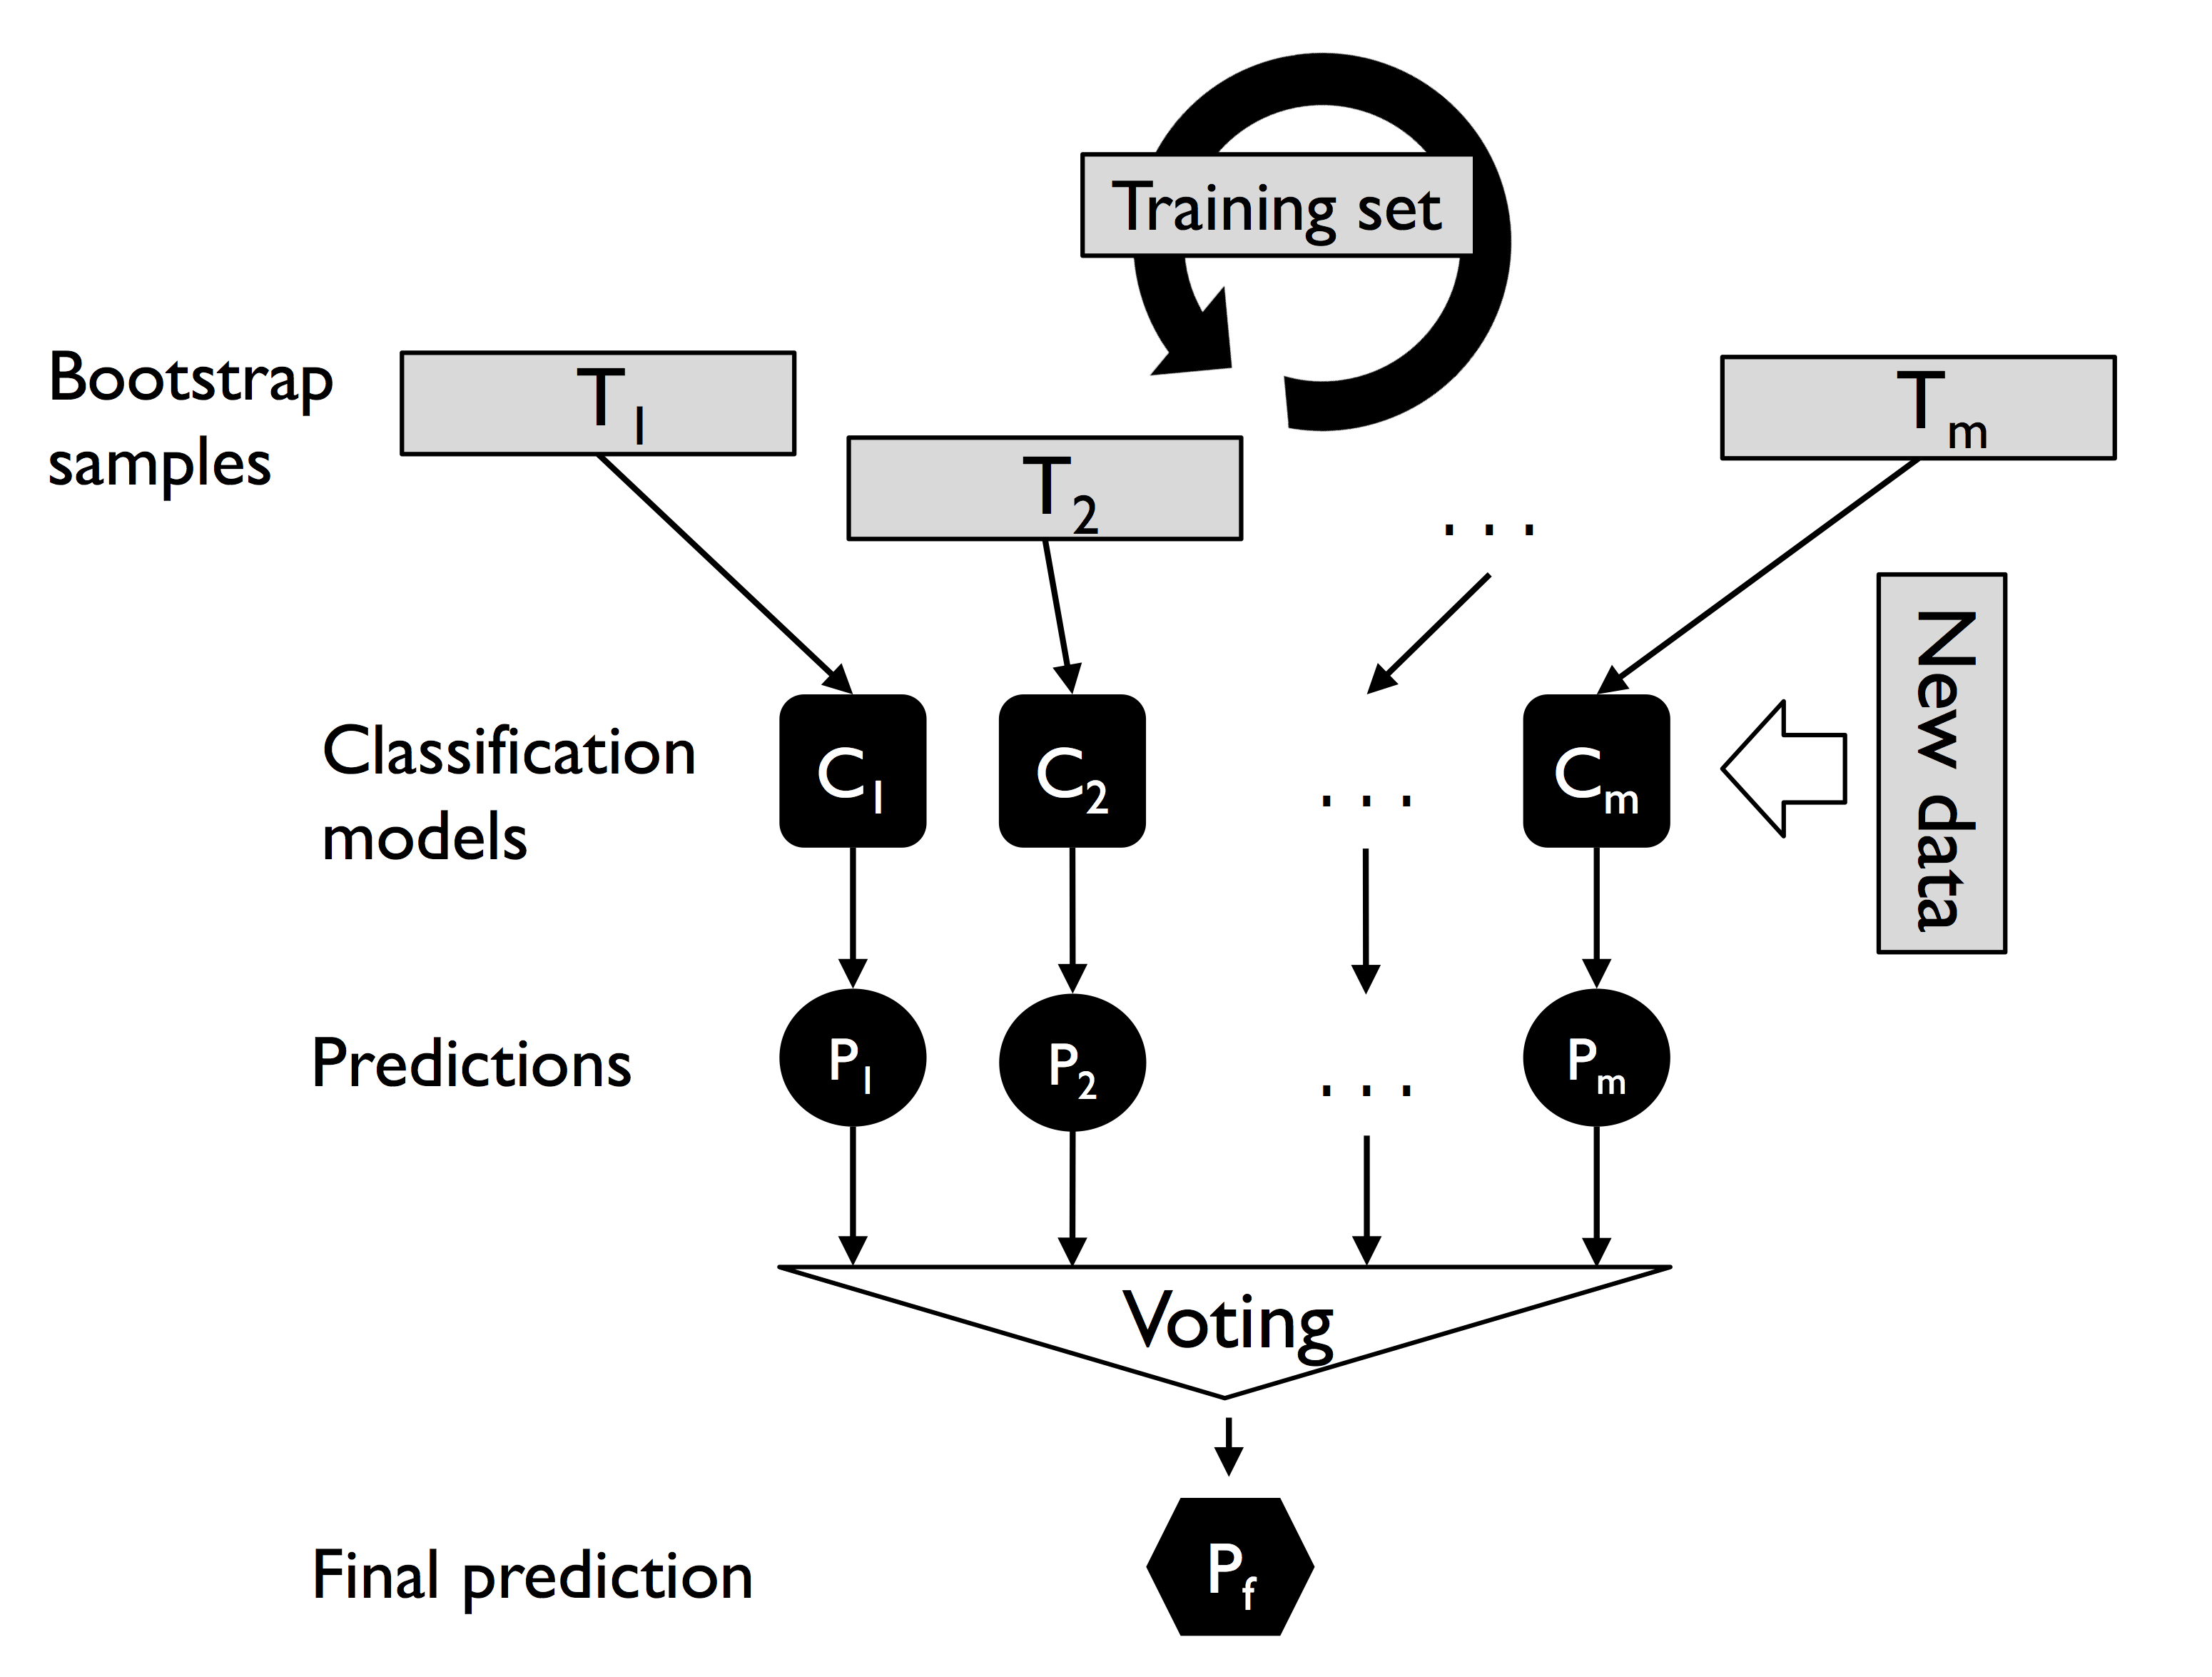

In [7]:
fig_num+=1
print(color.BOLD+color.UNDERLINE+"Figure %d: Bagging Classifier"%fig_num+color.END)

# From https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L07/07-ensembles__notes.pdf
#Image(os.path.join(image_dir, "bagging.png"), width=600)
# From https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch07/images/07_06.png
Image(os.path.join(image_dir, "07_06.png"), width=600)

Specifically, bagging is when sampling is produced with replacement<sup>6</sup>, and without replacement being called _pasting_<sup>7</sup>. 

Pasting is designed to use smaller sample sizes than the training dataset in cases where the training dataset does not fit into memory<sup>7</sup>.

Both bagging and pasting allow training to be sampled several times across multiple predictors, with bagging only allowing several samples for the same predictor <sup>3</sup>.

In [8]:
from sklearn.ensemble import BaggingClassifier
print(color.BOLD+color.UNDERLINE+"Original Data"+color.END)
example_np = pd.DataFrame(range(10)).values
display(example_np.flatten())

print(color.BOLD+color.UNDERLINE+"Bagging (0.8 Samples)"+color.END)
bag = BaggingClassifier(base_estimator=clf3,
                        n_estimators=5, 
                        random_state=42,
                        max_samples = 0.8,
                        bootstrap=True
                       ).fit(example_np,example_np.ravel())
display(bag.estimators_samples_)

print(color.BOLD+color.UNDERLINE+"Pasting (0.8 Samples)"+color.END)
bag.set_params(bootstrap=False).fit(example_np,example_np.ravel())
display(bag.estimators_samples_)

Original Data


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Bagging (0.8 Samples)


[array([9, 2, 9, 7, 7, 8, 3, 2]),
 array([7, 3, 7, 3, 9, 5, 3, 9]),
 array([6, 0, 7, 7, 9, 8, 5, 8]),
 array([0, 5, 7, 4, 1, 3, 6, 2]),
 array([6, 9, 6, 3, 3, 8, 3, 7])]

Pasting (0.8 Samples)


[array([6, 7, 5, 8, 3, 0, 4, 1]),
 array([0, 4, 5, 6, 2, 1, 8, 9]),
 array([5, 3, 9, 4, 8, 2, 1, 7]),
 array([9, 3, 6, 1, 8, 4, 2, 7]),
 array([1, 5, 4, 2, 0, 8, 7, 3])]

Averaging methods generally work best when the predictors are as independent as possible, so one way of achiving this is to get diverse classifiers<sup>3</sup>.

Bagging has been demonstrated to give impressive improvements in accuracy by combining together hundreds or even thousands of trees into a single procedure.

These trees are grown deep, and are not pruned so each individual tree has high variance, but low bias. Averaging these $B$ trees reduces the variance.

To apply bagging to _decision trees_, we simply:
1. construct $B$ decision trees using $B$ bootstrapped training sets, 
2. take a majority vote of the resulting predictions.

__Notes__
- Diverse classifiers increase the chance they each make different types of errors which in combination will improve the overall accuracy<sup>3</sup>.
- In practice, _bagging_ tends to work best with complex models<sup>5</sup>, so although bagging is useful when applied to regression methods, they are particularly useful for decision trees<sup>1</sup>.
- _boosting_ will generally work better with weak models.
- To apply bagging to __regression trees__, we simply:
    1. construct $B$ regression trees using $B$ bootstrapped training sets, 
    2. average the resulting predictions. 

## Out-of-Bag Error Estimation
Using a bagged model means we can get a validation/test error without using cross-validation.

As each tree does not use all observations for training, we can predict the remaining observations.

With a sufficiently large amount of bags, OOB error is virtually equivalent to leave-one-out cross-validation error, which is convenient when performing bagging on large data sets for which cross-validation would be computationally onerous<sup>1</sup>.

In [9]:
bag = BaggingClassifier(base_estimator=clf3, 
                        n_estimators=100, 
                        max_samples=0.8, 
                        max_features=1., 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        oob_score=True, 
                        warm_start=False,
                        n_jobs=-1, 
                        random_state=42)

start = time()
bag.fit(X_train, y_train)
calc_time = time() - start
print("Bagged OOB Accuracy: " + str(round(bag.oob_score_,2)) + " ("+str(round(calc_time, 2))+" secs)")

start = time()
LOO_ave = np.mean(cross_val_score(bag, X_train, y_train, cv=LeaveOneOut()))
calc_time = time() - start
print("Leave-one-out Cross-validation Accuracy: " + str(round(LOO_ave,2)) + " ("+str(round(calc_time, 2))+" secs)")

Bagged OOB Accuracy: 0.96 (1.9 secs)
Leave-one-out Cross-validation Accuracy: 0.96 (59.31 secs)


## Variable Importance Measures

Bagging improves prediction accuracy at the expense of interpretability.

However we can use the feature importance method as previously discussed, to get an overall summary of the importance of each predictor across trees.

__NOTES__
- Bagging can be used with most classifiers, although you can only assess feature importances if a method provides a `feature_importances_`.
- _"Recall that one of the advantages of decision trees is the attractive and easily interpreted diagram that results... However, when we bag a large number of trees, it is no longer possible to represent the resulting statistical learning procedure using a single tree, and it is no longer clear which variables are most important to the procedure."_<sup>1</sup>

In [12]:
# get the importances for the features
bag_importances = np.mean([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)

bag_importances_sd = np.std([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)

bag_importances_series = pd.Series(bag_importances,index=X.columns)

fig = plt.figure(figsize = (width_inch*1.2, height_inch*1.2))
# plot the important features
bag_importances_series.sort_index(ascending = False).plot.barh(legend =False, grid=False, xerr=bag_importances_sd)
fig_num+=1
plt.title('Figure %d: Average (and Standard Devision) Decision Tree Feature Importances in a Bagged Classifier'%fig_num)

plt.xlim(0,0.8)
plt.tight_layout()
plt.close()
display(MatplotlibFigure(fig, centered=True))

# 6. Random Forests <a id='forest'></a>

Random forests are among the most widely used machine learning algorithm<sup>8</sup>.

Random forests are essentally bagged tree classifiers, but decorrelate the trees by using a random sample of features each time a split in a tree is considered. The random forest algorithm can therefore be summarized in four steps<sup>4</sup>:

1. Draw a random bootstrap sample of size $n$.
2. Grow a decision tree from the bootstrap sample. At each node:

    a. Randomly select $d$ features without replacement (typically the square root of the total number of predictors).
    
     b. Split the node using the feature that provides the best split according to the objective function.

3. Repeat the steps above $k$ times.
4. Aggregate the prediction by each tree to assign the class label by majority vote.

__NOTES__
- Random forests fit decision trees on different bootstrap samples, and for each decision tree, select a random subset of features at each node to decide upon the optimal split. The feature subset to consider at each node is a hyperparameter that we can tune<sup>8</sup>.
- Instead of using majority vote, as was done in the origional publication<sup>9</sup>, in Sklearn the `RandomForestClassifier` averages the probabilistic prediction.
- Remember we cannot use `graphviz` or `sklearn.tree.plot_tree` on the whole forest as we did for the trees, as each tree is built differently.
- if a random forest is built using all features, then this is simply bagging.
- you can also bootstrap features in the `BaggingClassifier` using `bootstrap_features=True`

By not allowing the model to use the majority of the available predictors, we ensure the bagged trees look different from each other. 

If there is a particularly strong set of predictors in the data, then without randomly selecting features, the bagged trees will look quite similar to each other and predictions will be highly correlated. 

Averaging highly correlated quantities does not lead to as large of a reduction in variance as averaging many uncorrelated quantities<sup>1</sup>.

In [11]:
fig, axes = plt.subplots(ncols=2, figsize = (width_inch*2, height_inch*1.4), 
                         sharex=True, sharey=True)

# plot the important features
bag_importances_series.sort_index(ascending = False).plot.barh(legend =False, grid=False, ax=axes[0])
axes[0].set_title('Bagging')

plt.xlim(0,0.6)
plt.tight_layout()

RF = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            max_samples=0.8,
                            random_state=42,
                            n_jobs=-1)

RF.fit(X.values, y.values)

# get the importances for the features
rf_importances = RF.feature_importances_

rf_importances_series = pd.Series(rf_importances,index=X.columns).sort_index(ascending = False)

# plot the important features
rf_importances_series.plot.barh(legend =False, grid=False, ax=axes[1])
axes[1].set_title('Random Forest')

fig_num+=1
plt.suptitle('Figure %d: Average Feature Importances for Bagged Trees and a Random Forest'%fig_num)
plt.tight_layout()
plt.close()
display(MatplotlibFigure(fig, centered=True))

__Extra__

As a further example, we could look at the trees in our forest directly and see they are quite different.

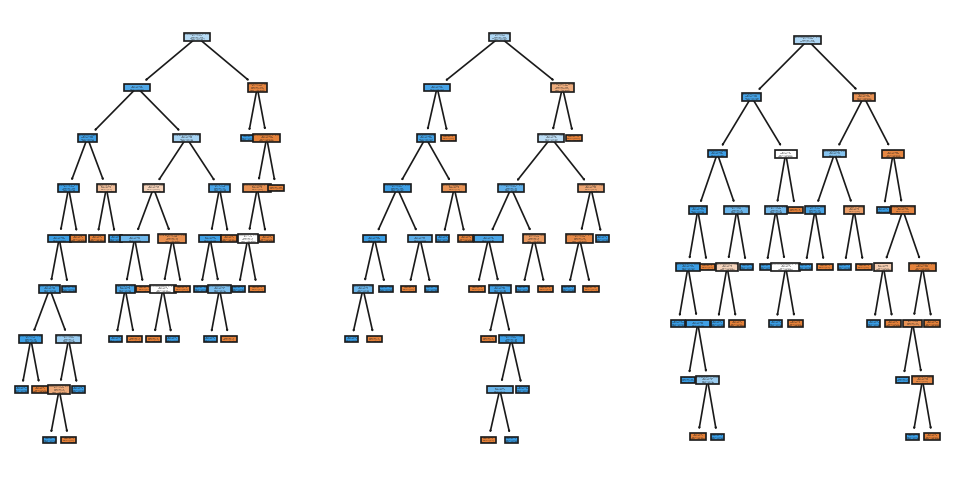

In [12]:
plot_trees = 3
fig, axes = plt.subplots(ncols=plot_trees, figsize=(10,5))
with plt.style.context("classic"):
    for i in range(plot_trees):
        plt.sca(axes[i])
        plot_tree(RF.estimators_[i],
                  feature_names=X.columns, 
                  class_names=load_breast_cancer().target_names,
                  filled = True)
    plt.show()

__Extra__<sup>8</sup>

Earlier random decision forests by Tin Kam Ho<sup>10</sup> used the _"random subspace method"_, where each tree got a random subset of features.
> “The essence of the method is to build multiple trees in randomly selected subspaces of the feature space.”

However, a few years later, Leo Breiman<sup>11</sup> described the procedure of selecting different subsets of features for each node; so each tree was given the full set of features. This formulation is now the typical _"random forest"_ algorithm
>“. . . random forest with random features is formed by selecting at random, at each node, a small group of input variables to split on.”

### Hyperparameters

Important parameters to adjust are<sup>13</sup>:
- `n_estimators`: Larger is generally better as averaging more trees will typically yield a more robust ensemble by reducing overfitting.
- `max_features`: Determines how random each tree is so smaller number of features at each split reduces overfitting.
- pre-pruning options (`max_depth`, `max_leaf_nodes`): more important for single trees, but can improve performance, reduce space, and time requirements.

__Notes__

- Typically you want to use as many estimators as you have time and memory for training.
    - Start with $p \times 10$ trees and adjust as necessary<sup>14</sup>.
- A good rule of thumb for `max_features` default values are `max_features=sqrt(n_features)` for classification and `max_features=n_features` for regression<sup>13</sup>.
    - Start with a few evenly spaced values across the range 2–$p$<sup>14</sup>.
-  _"Segal (2004) showed that if your data has many noisy predictors and higher [`max_features`] values are performing best, then performance may improve by increasing node size (i.e., decreasing tree depth and complexity). Moreover, if computation time is a concern then you can often decrease run time substantially by increasing the node size and have only marginal impacts to your error estimate..."_<sup>14</sup>
- For a more thorough discussion of forest hyperparameters, see: Probst, Philipp, Bernd Bischl, and Anne-Laure Boulesteix. 2018. “Tunability: Importance of Hyperparameters of Machine Learning Algorithms.” arXiv Preprint arXiv:1802.09596.

In [13]:
RF = RandomForestClassifier(criterion='gini',
                            random_state=42,
                            oob_score = True,
                            n_jobs=-1)
n_estimators_list = list(range(0, 1050, 50))
n_estimators_list[0] = 1

max_feats_list = list(range(0, X_train.shape[1]+6, 6))
max_feats_list[0] = 2

oob_scores = pd.DataFrame()
for n in n_estimators_list:
    for f in max_feats_list:
        RF.set_params(**{'n_estimators':n, 'max_features':f})
        with warnings.catch_warnings(record=True) as w:
            # Cause all warnings to always be triggered.
            warnings.simplefilter("always")
            try:
                RF.fit(X_train, y_train)
                score = RF.oob_score_
            except:
                score = 0.
                
            oob_score = pd.DataFrame([n, f, score], index = ['Estimators', 'Max Features', 'OOB Score']).T
            if oob_scores.empty:
                oob_scores = oob_score
            else:
                oob_scores = pd.concat([oob_scores,oob_score])

In [14]:
fig, axes = plt.subplots(2, figsize = (width_inch*2, height_inch*2), sharex=True)

plt.sca(axes[1])
sns.lineplot(data = oob_scores, x = 'Estimators', y = 'OOB Score', hue = 'Max Features')
axes[1].set_ylim([0.5,1.])
axes[1].set_xlim([-10.,1100])
plt.legend([],[], frameon=False)
plt.sca(axes[0])
sns.lineplot(data = oob_scores, x = 'Estimators', y = 'OOB Score', hue = 'Max Features')
axes[0].set_ylim([0.95,0.98])
axes[0].set_xlim([-10.,1100])

fig_num+=1
plt.suptitle('Figure %d: `n_estimators` and `max_features` for Random Forest Performance'%fig_num)
plt.tight_layout()
plt.close()
display(MatplotlibFigure(fig, centered=True))
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
def hyper_search(model, params, X, y, save_path, n_iter=60, metric="accuracy", 
                 cv = KFold(5), random_state=42, refit=True,
                 overwrite=False, warning=False):
    if os.path.exists(save_path) and overwrite==False:
        #load the model
        models = joblib.load(save_path)
    else:
        # check all param inputs are lists
        if all(type(x)==list for x in params.values()):
            search_type = "Gridsearch"
            models = GridSearchCV(model, param_grid=params, scoring=metric, cv=cv, 
                                  refit=refit, return_train_score=True)
            n_iter = len(list(itertools.product(*list(iter(params.values())))))
        else:
            search_type = "Randomsearch"
            models = RandomizedSearchCV(model, param_distributions=params,
                                        n_iter=n_iter, scoring=metric, cv=cv,
                                        refit=refit, random_state=random_state,
                                        return_train_score=True)
        
        start = time()
        if warning:
            models.fit(X, y)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                models.fit(X, y)
        
        print(search_type + " took %.2f seconds for %d candidates" % ((time() - start), n_iter))
        joblib.dump(models, save_path)
    
    return models

In [16]:
RF = RandomForestClassifier(criterion='gini',
                            random_state=42,
                            n_jobs=-1)

rf_param_dict = {'n_estimators': n_estimators_list,
                 'max_features': max_feats_list}

# tbf a random search here would be better but I guess I'm doing this for comparison
# with the previous plot.
rf_gs = hyper_search(RF, rf_param_dict, X_train, y_train,
                     os.path.join(os.getcwd(), "Models", "rf_gs.pkl"),
                     overwrite=False)
display(pd.DataFrame(rf_gs.cv_results_).sort_values("rank_test_score")[["param_n_estimators",
                                                                        "param_max_features",
                                                                        "mean_test_score", 
                                                                        "std_test_score"]].head())

param_n_estimators param_max_features  mean_test_score  std_test_score
36                750                  6         0.961454         0.02678
35                700                  6         0.961454         0.02678
34                650                  6         0.961454         0.02678
33                600                  6         0.961454         0.02678
31                500                  6         0.961454         0.02678

In [17]:
# from https://realpython.com/python-timer/

import time

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        #print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return elapsed_time

In [18]:
max_min_samples = 41

min_samples_leaf_list = list(range(1, max_min_samples))
RF = rf_gs.best_estimator_
t = Timer()

oob_scores = pd.DataFrame()
for s in min_samples_leaf_list:
    RF.set_params(**{'min_samples_leaf':s, 'oob_score':True})
    t.start()
    RF.fit(X_train, y_train)
    score = RF.oob_score_
    func_time = t.stop()
    oob_score = pd.DataFrame([s, score, func_time], index = ['Minimum Samples per Leaf', 'OOB Score', 'Run Time (secs)']).T
    if oob_scores.empty:
        oob_scores = oob_score
    else:
        oob_scores = pd.concat([oob_scores,oob_score])

Well in this case theres not much impact on run time, but there often is (see https://bradleyboehmke.github.io/HOML/random-forest.html)

In [19]:
fig, axes = plt.subplots(2, figsize = (width_inch*2, height_inch*2), sharex=True)

plt.sca(axes[0])
sns.lineplot(data = oob_scores, x = 'Minimum Samples per Leaf', y = 'OOB Score')
axes[0].set_ylim([0.93,0.97])
axes[0].set_xlim([-1.,max_min_samples])

plt.sca(axes[1])
sns.lineplot(data = oob_scores, x = 'Minimum Samples per Leaf', y = 'Run Time (secs)')
axes[1].set_ylim([0.5,1.2])
axes[0].set_xlim([-1.,max_min_samples])

fig_num+=1
plt.suptitle('Figure %d: Reduction in Tree Complexity and Impact on Computation Speed'%fig_num)
plt.tight_layout()
plt.close()
display(MatplotlibFigure(fig, centered=True))
plt.show()

## Extremely Randomized Trees<sup>12</sup>
As averaging methods work best when the predictors are as independent as possible<sup>5</sup>, we may specifically want our trees in our ensemble to be more independent. 

Instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule.

__Notes__

- An extratree is similar to a tree classifier except it more randomized and therefore produces more complex trees. 
- When used in an ensemble, this usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias<sup>5</sup>.
- As we can see how just one tree looks, this is a very complex model!

In [20]:
from sklearn.tree import ExtraTreeClassifier

ET = ExtraTreeClassifier(criterion='gini',
                         random_state=42,
                         max_depth = None)

ET.fit(X.values, y.values)

fig, axes = plt.subplots(figsize = (width_inch*2, height_inch*2))
with plt.style.context("classic"):
    plot_tree(ET,
              feature_names=X.columns, 
              class_names=load_breast_cancer().target_names,
              filled = True)
fig_num+=1
plt.suptitle('Figure %d: Extremely Randomised Trees'%fig_num)
plt.close()
display(MatplotlibFigure(fig, centered=True))

# Associated Exercises

Now might be a good time to try exercises 7-10.

# References
1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
2. Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
4. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
5. https://scikit-learn.org/stable/modules/ensemble.html
6. Breiman, L. (1996). Bagging predictors. Machine learning, 24(2), 123-140.
7. Breiman, L. (1999). Pasting small votes for classification in large databases and on-line. Machine learning, 36(1-2), 85-103.
8. https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L07/07-ensembles__notes.pdf
9. L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001
10. Tin Kam Ho. “Random decision forests”. In: Document analysis and recognition, 1995., proceedings of the third international conference on. Vol. 1. IEEE. 1995, pp. 278–282.
11. Leo Breiman. “Random forests”. In: Machine learning 45.1 (2001), pp. 5–32.
12. Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. Machine learning, 63(1), 3-42.
13. Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: a guide for data scientists. " O'Reilly Media, Inc.".
14. https://bradleyboehmke.github.io/HOML/random-forest.html

In [21]:
import sys
from shutil import copyfile

# where the HTML template is located
dst = os.path.join(sys.prefix, 'lib', 'site-packages', 'nbconvert', 'templates', "classic.tplx")

# If its not located where it should be
if not os.path.exists(dst):
    # uses a nb_pdf_template
    curr_path = os.path.join(os.getcwd(),"..", "Extra", "classic.tplx")
    # copy where it is meant to be
    copyfile(curr_path, dst)

   
# Create HTML notes document (preferred)
!jupyter nbconvert 2_Ensemble_Averaging.ipynb \
    --to html \
    --output-dir . \
    --template classic
# Create html slides (issues)
!jupyter nbconvert 2_Ensemble_Averaging.ipynb \
    --to slides \
    --output-dir . \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True \
    --SlidesExporter.reveal_scroll=True

# Create pdf notes document (issues)
!jupyter nbconvert 2_Ensemble_Averaging.ipynb \
    --to html \
    --output-dir ./PDF_Prep \
    --output 2_Ensemble_Averaging_no_code \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True

[NbConvertApp] Converting notebook 2_Ensemble_Averaging.ipynb to html
[NbConvertApp] Writing 1653042 bytes to 2_Ensemble_Averaging.html
[NbConvertApp] Converting notebook 2_Ensemble_Averaging.ipynb to slides
[NbConvertApp] Writing 1740511 bytes to 2_Ensemble_Averaging.slides.html
[NbConvertApp] Converting notebook 2_Ensemble_Averaging.ipynb to html
[NbConvertApp] Writing 1858265 bytes to PDF_Prep\2_Ensemble_Averaging_no_code.html
